In [753]:
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

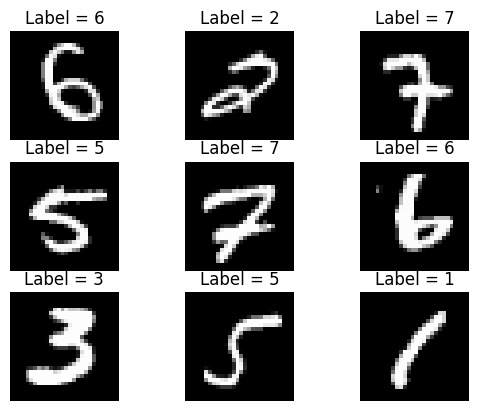

In [754]:
np.random.seed(1)  

mnist = fetch_openml('mnist_784')

X = mnist.data.to_numpy().reshape(-1,28,28)
Y = mnist.target.to_numpy()
shuffle = np.random.permutation(70000)
Xtrain, Xtest = X[shuffle[:60000]], X[shuffle[60000:]]
Ytrain, Ytest = Y[shuffle[:60000]], Y[shuffle[60000:]]

fig, axs = plt.subplots(3,3)
for i in range(len(axs)):
	for j in range(len(axs[0])):
		axs[i][j].imshow(Xtrain[len(axs)*i + j], interpolation='none', cmap='gray')
		axs[i][j].set_title(f'Label = {Ytrain[len(axs)*i + j]}')
		axs[i][j].axis('off')
plt.show()

In [755]:
xtrain = torch.FloatTensor(Xtrain.tolist()) #convert the xtrain data to tensor list
ytrain_int = Ytrain.astype(int) #convert the ytrain data to int
ytrain = torch.FloatTensor(ytrain_int.tolist()) #convert the ytrain data to tensor list

xtest = torch.FloatTensor(Xtest.tolist()) #convert the xtest data to tensor list
ytest_int = Ytest.astype(int) #convert the ytest data to int 
ytest = torch.FloatTensor(ytest_int.tolist()) #convert the xtest data to tensor list

In [756]:
train_dataset = TensorDataset(xtrain, ytrain) #convert the xtrain and ytrain data into one tensor dataset
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(xtest, ytest) #convert the xtest and ytest data into one tensor dataset
test_loader = DataLoader(test_dataset, batch_size=64)

In [757]:
#FULLY CONNECTED NETWORK

# Hyperparameters
input_size = 784
num_class = 10
learning_rate = 0.001
num_epochs = 5

In [758]:
#Network implementation
class NN(nn.Module):  # inherits nn.Module
    def __init__(self, input_size, num_classes):  # input size = 28x28 = 784 for mnist
        super(NN,self).__init__()
        self.linear1 = nn.Linear(input_size, 64) 
        self.linear2 = nn.Linear(64, 32) 
        self.final = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x): #convert + flatten
        x = x.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [759]:
# Initialize Network
model = NN(input_size=input_size, num_classes=num_class)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [760]:
# Train Network
for epoch in range(num_epochs):  
    for batch_idx, (data, targets) in enumerate(train_loader):
        
        data = data.reshape(data.shape[0], -1)  # Flatten

        # forward
        scores = model(data)
        
        targets = targets.long()
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

In [761]:
def test(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:

            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')
    model.train()


print("Fully connected network accuracy of the training data")
test(train_loader, model)
print('\n')
print("Fully connected network accuracy of the testing data")
test(test_loader, model)

Fully connected network accuracy of the training data
Got 58428/60000 with accuracy  97.38


Fully connected network accuracy of the testing data
Got 9631/10000 with accuracy  96.31


In [762]:
#CONVOLUTIONAL NETWORK

# Hyperparameters
num_class=10
in_channel = 1  # => Changed parameter
learning_rate = 0.001
num_epochs = 5

In [763]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 1, 28,28)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        
        x = x.view(-1, 256)
        x = self.relu(self.fc1(x))   
        x = self.fc2(x)
        return x
    

In [764]:
# Initialize Network
model = CNN(in_channels=in_channel, num_classes=num_class)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [765]:
# Train Network
for epoch in range(num_epochs):      
    for batch_idx, (data, targets) in enumerate(train_loader):

        # forward
        scores = model(data)
        
        targets = targets.long()
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

In [766]:
def test(loader, model):

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')
    model.train()

print("Convolutional network accuracy of the training data")
test(train_loader, model)
print('\n')
print("Convolutional network accuracy of the testing data")
test(test_loader, model)

Convolutional network accuracy of the training data
Got 59421/60000 with accuracy  99.03


Convolutional network accuracy of the testing data
Got 9848/10000 with accuracy  98.48
